In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

#image and output formatting
import PIL
from PIL import Image
from tabulate import tabulate

#dir manip libraries
import os, sys, glob, pathlib, tempfile
from pathlib import Path

#import label encoding
from sklearn.preprocessing import LabelEncoder

#keras for model output customization
import keras
from keras import layers, ops

#tensorflow tools for model building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam, SGD

# Custom functions (this works, finally)
from pyTools.utils import *
from pyTools.preprocess import *
from pyTools.predict import *

# Print out versions for important tools
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Pillow version:", PIL.__version__)

Pandas version: 2.1.4
TensorFlow version: 2.16.1
Pillow version: 10.2.0


In [2]:
# Define the path to your Google Drive folder containing the images
data_dir = Path("../ML_Asm2_ProjFiles/classify_by_shape")

# Ensure the directory exists
if not data_dir.exists():
    raise ValueError(f"Directory {data_dir} does not exist. Please check the path.")

In [3]:
image_count = len(list(data_dir.glob('*/**/*.png')))
print(image_count)

19825


In [4]:
print_directory_tree(data_dir)

├───preview/
    ├───diamond/
    ├───hex/
    ├───round/
    ├───square/
    ├───triangle/


In [5]:
print_summary(data_dir)

+-----------+------------------+
| Directory | Number of Images |
+-----------+------------------+
|  diamond  |       3965       |
|    hex    |       3965       |
|   round   |       3965       |
|  square   |       3965       |
| triangle  |       3965       |
+-----------+------------------+


In [6]:
#print_duplicates(data_dir)

In [7]:
# Get all images in the "bicycle" subdirectory (recursively)
bicycle_images = list(data_dir.glob('**/diamond/*'))

# Open the third image (indexing starts from 0, so the third image is at index 2)
img = PIL.Image.open(bicycle_images[2])

# Get image dimensions
width, height = img.size

# Print the dimensions
print("The dimensions of the image are:", width, "x", height)
img

The dimensions of the image are: 28 x 28


In [8]:
# Create the dataset and get the total image count
data = data_from_dir(data_dir)
print("Classes:", data.class_names)

Found 19825 files belonging to 5 classes.
Classes: ['diamond', 'hex', 'round', 'square', 'triangle']


In [9]:
data.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
data.cardinality().numpy()

100

[[[ 23]
  [ 29]
  [ 32]
  [ 34]
  [ 42]
  [ 51]
  [ 76]
  [107]
  [133]
  [155]
  [165]
  [152]
  [142]
  [129]
  [139]
  [142]
  [112]
  [ 97]
  [100]
  [128]
  [160]
  [206]
  [234]
  [253]
  [222]
  [162]
  [135]
  [130]]

 [[ 19]
  [ 25]
  [ 31]
  [ 32]
  [ 36]
  [ 45]
  [ 58]
  [ 85]
  [118]
  [140]
  [162]
  [161]
  [149]
  [138]
  [152]
  [159]
  [139]
  [137]
  [138]
  [196]
  [236]
  [255]
  [218]
  [158]
  [135]
  [129]
  [ 98]
  [ 54]]

 [[ 16]
  [ 21]
  [ 27]
  [ 33]
  [ 32]
  [ 39]
  [ 47]
  [ 66]
  [ 95]
  [125]
  [147]
  [168]
  [145]
  [161]
  [177]
  [190]
  [186]
  [143]
  [152]
  [166]
  [201]
  [153]
  [135]
  [129]
  [ 94]
  [ 50]
  [ 37]
  [ 35]]

 [[ 14]
  [ 17]
  [ 23]
  [ 29]
  [ 32]
  [ 33]
  [ 42]
  [ 50]
  [ 75]
  [106]
  [127]
  [134]
  [ 95]
  [ 74]
  [124]
  [128]
  [143]
  [132]
  [128]
  [141]
  [145]
  [129]
  [ 91]
  [ 47]
  [ 37]
  [ 35]
  [ 36]
  [ 39]]

 [[ 14]
  [ 14]
  [ 19]
  [ 25]
  [ 31]
  [ 32]
  [ 36]
  [ 44]
  [ 61]
  [ 95]
  [ 69]
  [ 39]


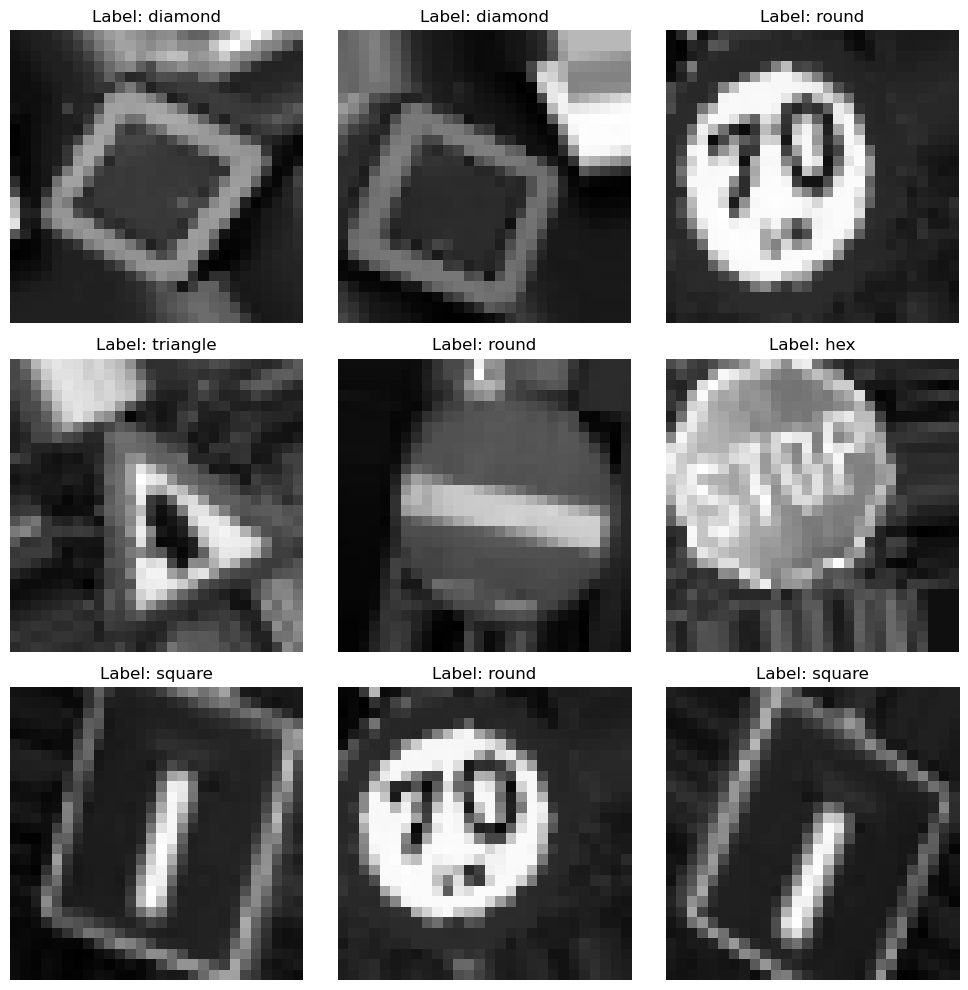

In [11]:
# Convert the class names to a NumPy array for easy indexing
class_names = np.array(data.class_names)

# Load the first batch from the training dataset
plt.figure(figsize=(10, 10))  # Define the figure size for a grid of images
for images, labels in data.take(1):
    # Plot 9 images in a 3x3 grid
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot in a 3x3 grid
        img = images[i].numpy().astype("uint8")  # Convert tensor to NumPy array
        print(img)
        # Use the numerical label to get the class name
        class_label = labels[i].numpy()  # Get the numerical label
        class_name = class_names[class_label]  # Get the corresponding class name

        plt.imshow(img, cmap='gray')  # This forces grayscale plotting

        plt.title(f"Label: {class_name}")  # Set the title with the class name
        plt.axis("off")  # Hide the axis for clarity

    plt.tight_layout()  # Adjust the layout for better spacing
    plt.show()  # Display all 9 images in a single plot


In [12]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

***compile()***:
  - ***optimizer***: Stochastic Gradient Descent, **Adoptive Moment Estimator(Adam)**
  - ***loss***: **Categorical (Focal) Cross Entropy**
  - ***metrics***: **(Categorical) Accuracy**, Top K Categorical, Categorical Cross Entropy, F1/Precision/Recall, AUC, IoU, MeanIoU

Initial design for baseline model.
Our goal was to design a simple Multilayer Perceptron baseline that utilizes keras libraries and utilities. Partially because of keras's versatility as a highly customisable tool, this model poses as a milestone for us to implement different modifications and tunings in development in the next steps.

In [15]:
# Define or compile the model
import tensorflow as tf

MLP = Sequential([
    keras.Input(shape=(28, 28, 1)),
    Rescaling(1/255),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax'), #This is fixed for multiclass classification
])

MLP.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['sparse_categorical_accuracy']
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Train the model with the given class weights dictionary
hist = MLP.fit(
    train,  # Your training data
    epochs=10,
    validation_data=val,  # Your validation data
    callbacks=[tensorboard_callback],  # Any additional callbacks you might need
)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.9694 - sparse_categorical_accuracy: 0.6916 - val_loss: 1.7802 - val_sparse_categorical_accuracy: 0.2828
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.4684 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.6872 - val_sparse_categorical_accuracy: 0.7983
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.3917 - sparse_categorical_accuracy: 0.8831 - val_loss: 0.3697 - val_sparse_categorical_accuracy: 0.8845
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.3659 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.3408 - val_sparse_categorical_accuracy: 0.8882
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.3392 - val_sparse_categorical_accuracy: 0.8870
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.3141 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.3002 - val_sparse_categorical_accuracy: 0.8980
Epoch 7/10

In [16]:
# Evaluate the model
loss, accuracy = MLP.evaluate(test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.9065
Test loss: 0.29209285974502563
Test accuracy: 0.9134246706962585


In [17]:
MLP.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,607,697 (6.13 MB)

 Trainable params: 535,557 (2.04 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 1,071,116 (4.09 MB)

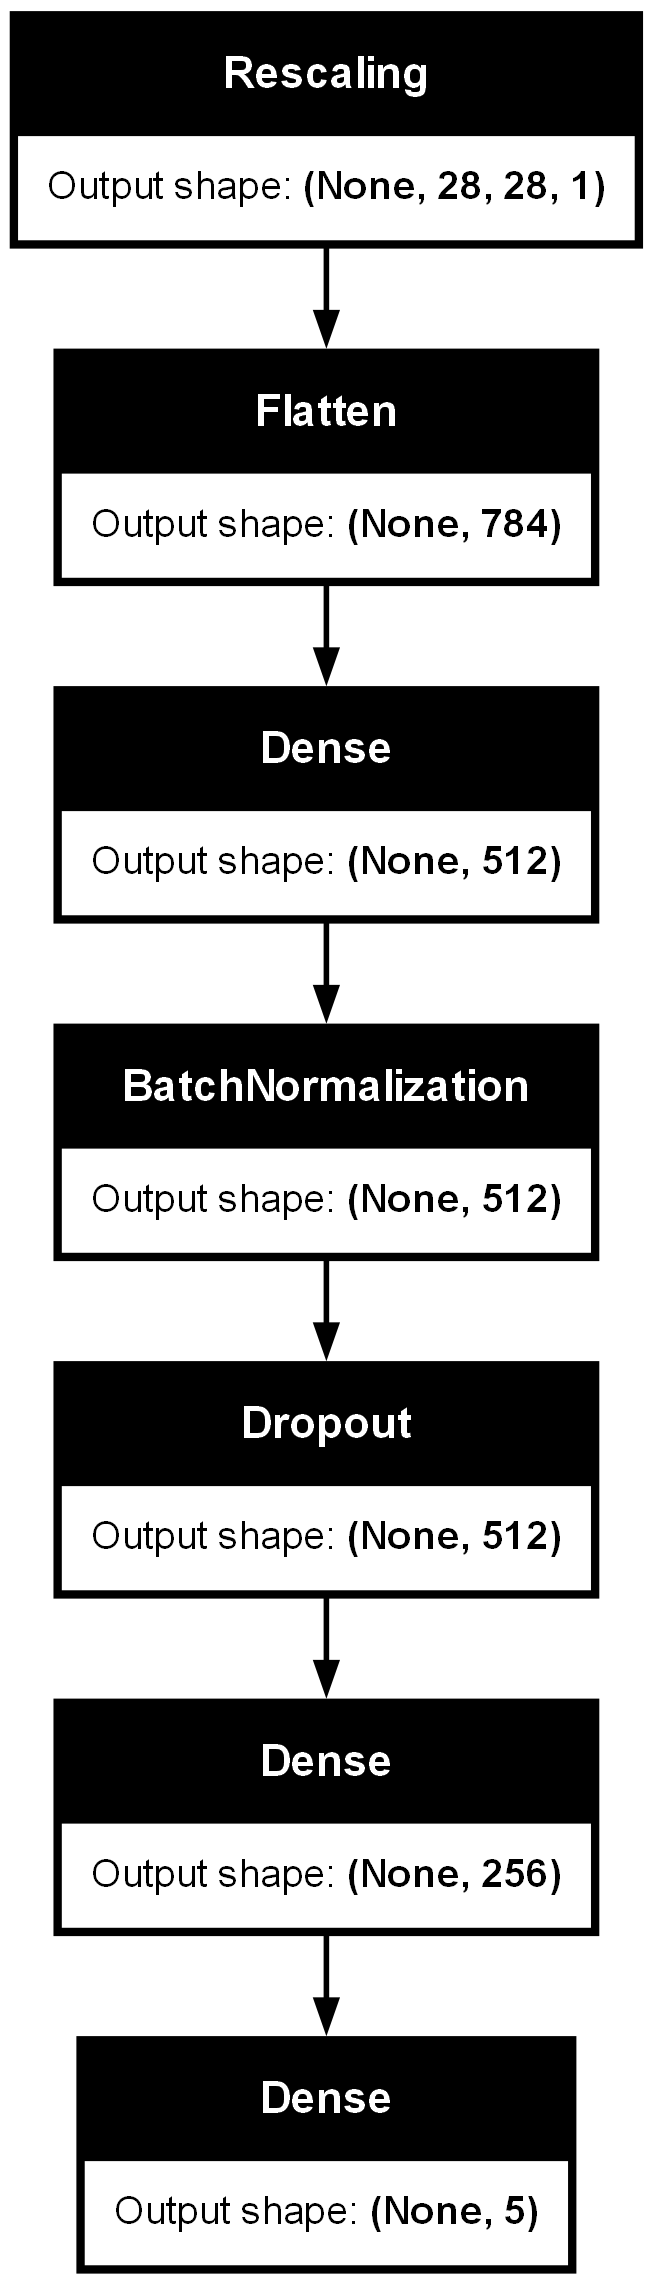

In [18]:
keras.utils.plot_model(MLP, show_shapes=True)

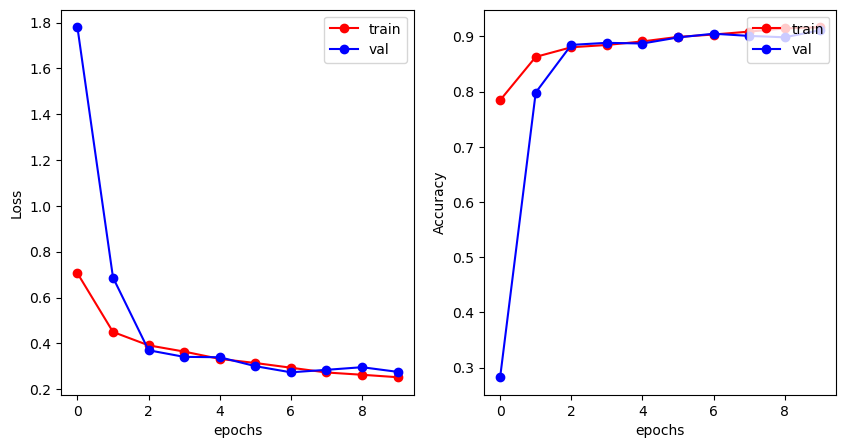

In [19]:
# Extract loss and metric values
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_metric = hist.history['sparse_categorical_accuracy']
val_metric = hist.history['val_sparse_categorical_accuracy']

# Plot the learning curve
plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy')

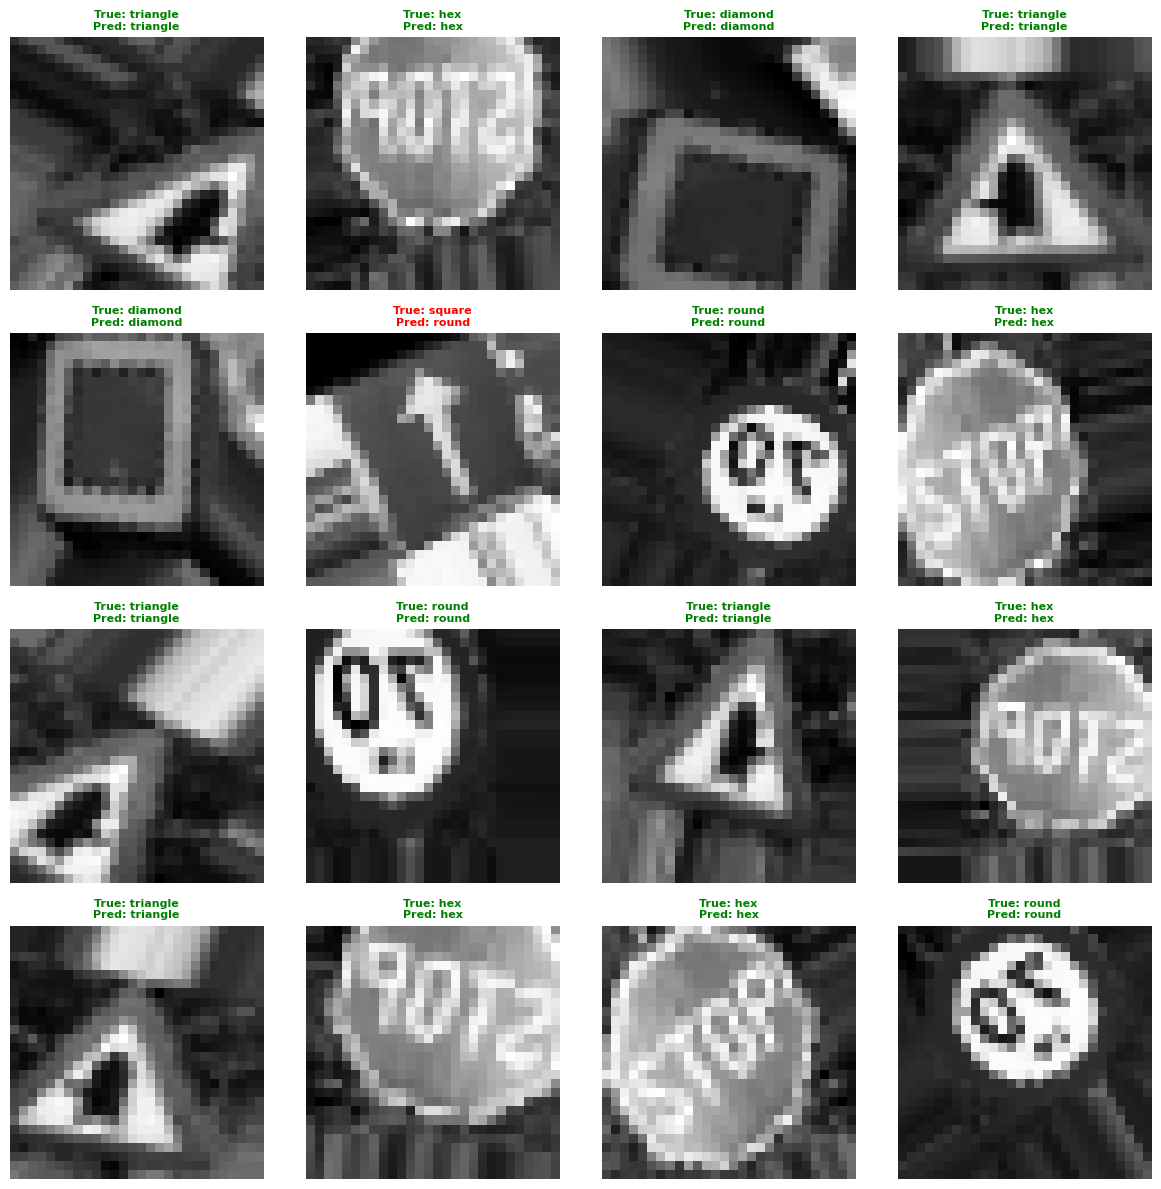

In [20]:
vResults_tf(MLP, val, data.class_names)

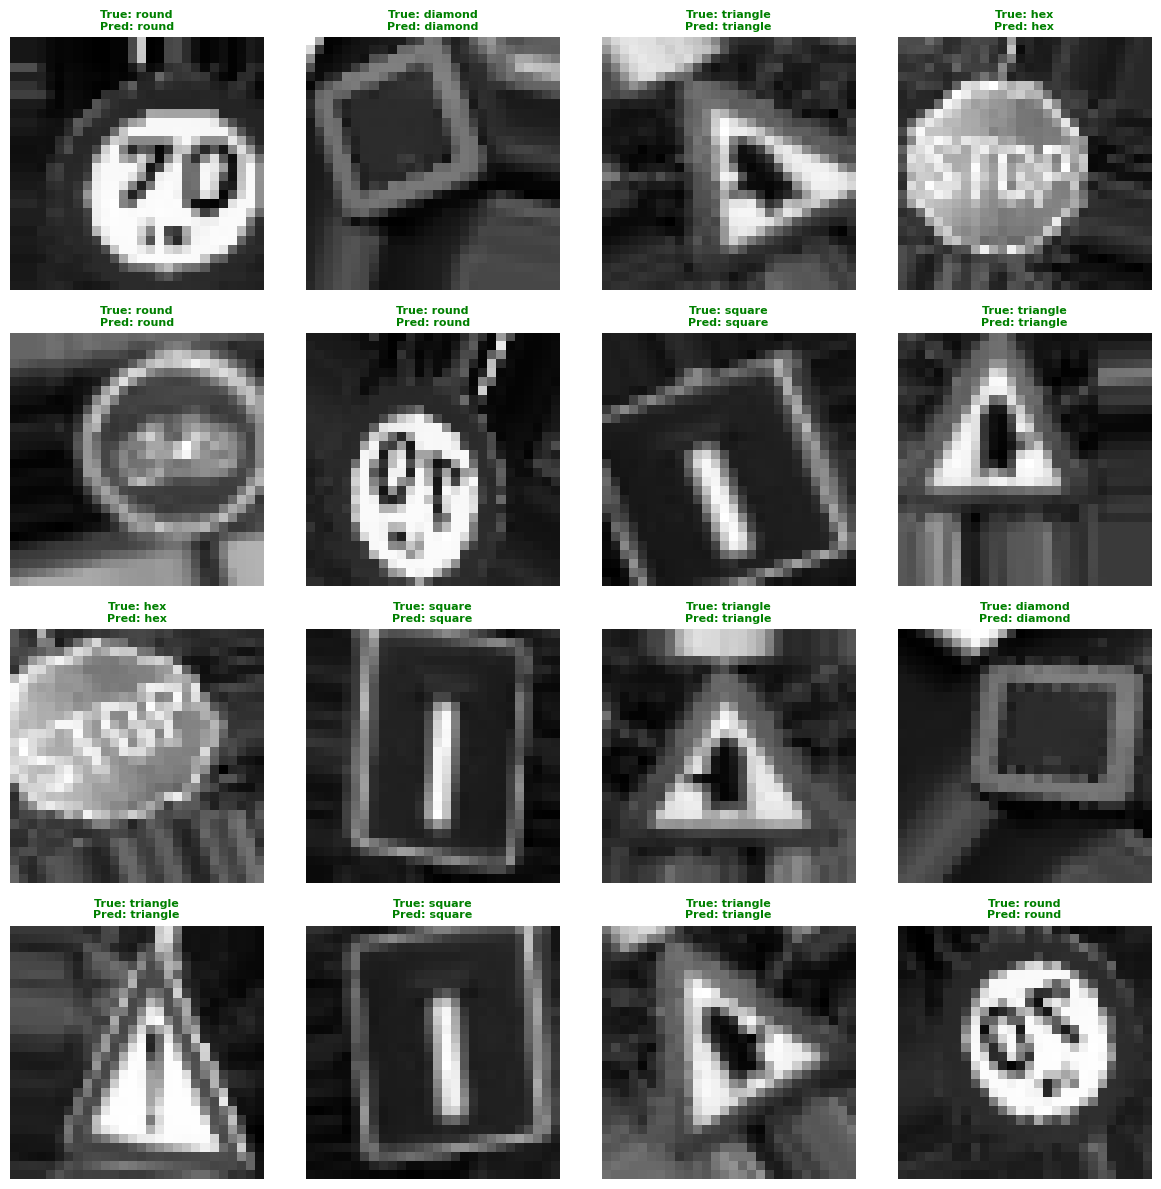

In [21]:
vResults_tf(MLP, test, data.class_names)

In [22]:
trueData = Path("../ML_Asm2_ProjFiles/tsrd-train")

In [23]:
image_count = len(list(trueData.glob('*.png')))
print(image_count)

4170


In [24]:
external_dir = "../ML_Asm2_ProjFiles/tsrd-train"  # Path to your dataset
raw_data = []

# Loop through all image files in the specified directory
for img_file in os.listdir(external_dir):
    if img_file.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        # Get the full path to the image
        img_path = os.path.join(external_dir, img_file)
        
        # Preprocess the image using the defined function
        preprocessed_img = preprocess28(img_path)
        
        # Add the preprocessed image to the raw_data list
        raw_data.append(preprocessed_img)

# Shuffle the images to randomize the order
random.shuffle(raw_data)

# Convert the list to a NumPy array
raw_data = np.array(raw_data)

In [25]:
raw_data[0]

array([[[121],
        [111],
        [125],
        [161],
        [107],
        [ 95],
        [ 54],
        [ 67],
        [110],
        [126],
        [110],
        [ 78],
        [ 66],
        [100],
        [123],
        [ 95],
        [ 67],
        [ 66],
        [ 87],
        [108],
        [117],
        [117],
        [ 90],
        [ 98],
        [125],
        [142],
        [123],
        [108]],

       [[109],
        [130],
        [118],
        [105],
        [ 91],
        [ 67],
        [ 91],
        [121],
        [ 97],
        [ 70],
        [ 74],
        [107],
        [134],
        [140],
        [139],
        [136],
        [126],
        [111],
        [ 80],
        [ 59],
        [ 60],
        [ 93],
        [ 92],
        [ 92],
        [128],
        [130],
        [110],
        [120]],

       [[166],
        [151],
        [126],
        [122],
        [ 95],
        [ 75],
        [ 67],
        [ 62],
        [ 78],
        [117],
      

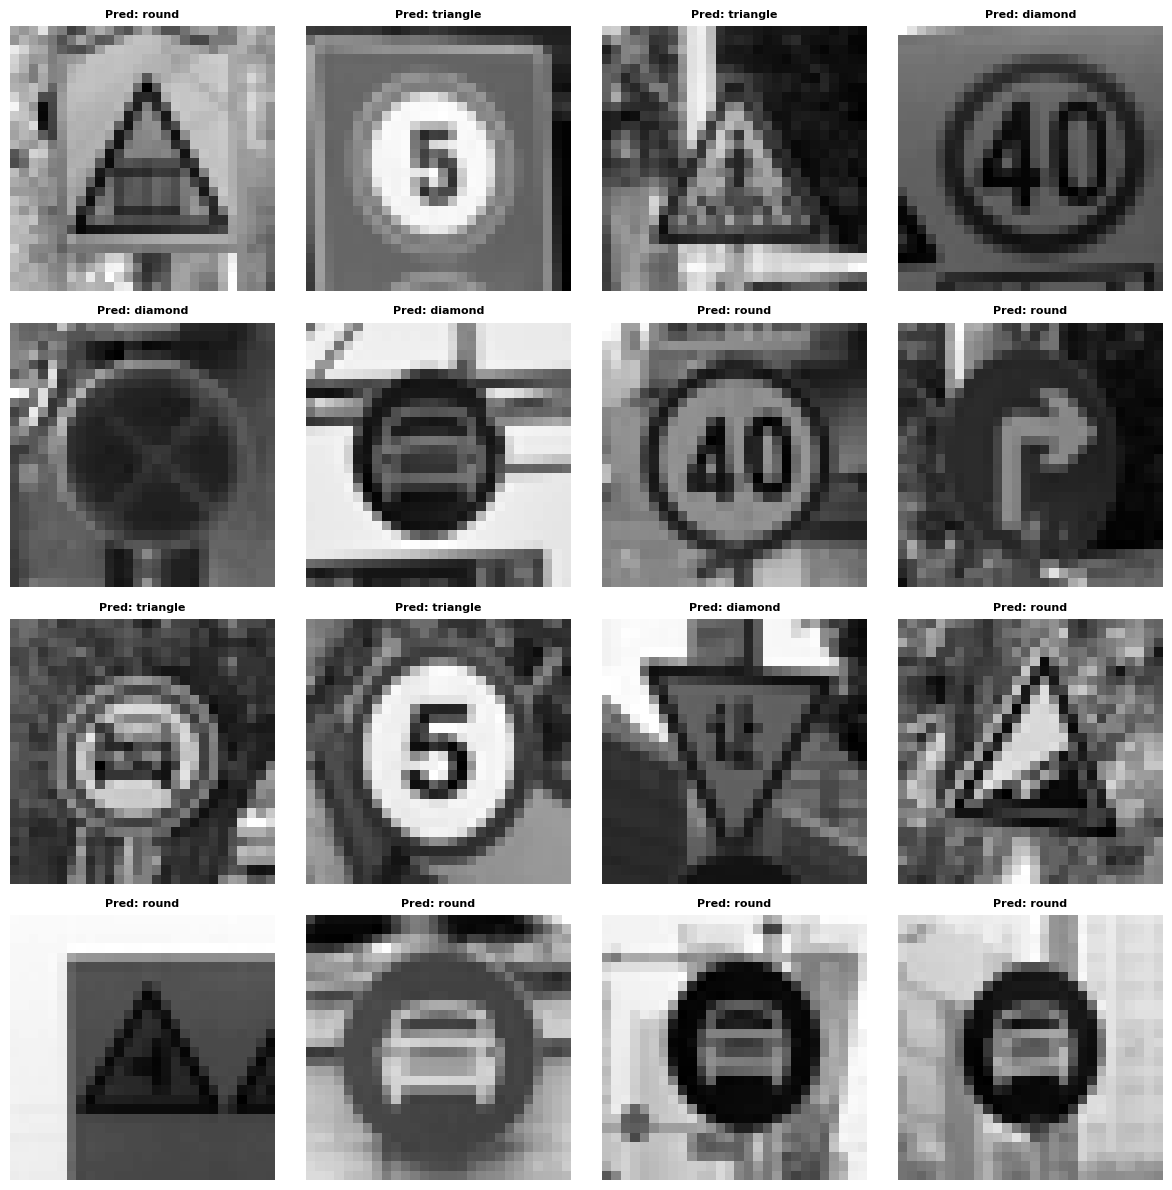

In [26]:
vResults_raw(MLP, raw_data, data.class_names)

# Notes: 
    Baseline model: 
     - Strength: 
     1. Classify data in the same dataset with very high accuracy. 
     2. Not computationally expensive
     
     - Weakness: 
     1. Inconsistent output metrics in each epoch. 
     2. Poor classification for external data
        -> Cause: Overfitting, Rudimentary Model. 

    Conclusion: Although the model did not perform well on external data, it reached a certain degree of generalization, which is fairly enough for this stage. 